In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('RespRate_interpolated_data.csv')
data.head(10)

,PatientID,Timestamp,Metric,Value
0,132543,0.00,RespRate,17.0
1,132543,0.01,RespRate,17.0
2,132543,0.02,RespRate,17.0
3,132543,0.03,RespRate,17.0
4,132543,0.04,RespRate,17.0
5,132543,0.05,RespRate,17.0
6,132543,0.06,RespRate,17.0
7,132543,0.07,RespRate,17.0
8,132543,0.08,RespRate,17.0
9,132543,0.09,RespRate,17.0


In [4]:
data.Timestamp = data.Timestamp * 100

In [5]:
data = data.set_index('Timestamp', drop=True)

In [6]:
data.head(10)

,PatientID,Metric,Value
Timestamp,,,
0.0,132543,RespRate,17.0
1.0,132543,RespRate,17.0
2.0,132543,RespRate,17.0
3.0,132543,RespRate,17.0
4.0,132543,RespRate,17.0
5.0,132543,RespRate,17.0
6.0,132543,RespRate,17.0
7.0,132543,RespRate,17.0
8.0,132543,RespRate,17.0


In [7]:
p_ids = [138022, 141560, 142580]

In [8]:
patient_data = data[data.PatientID == 142580]

In [9]:
patient_data_series =  patient_data.Value.reset_index(drop=True)

In [10]:
len(patient_data_series)

2901

In [11]:
test_data_series = patient_data_series[-100:]

In [12]:
patient_data_series = patient_data_series[:-100]

In [13]:
len(patient_data_series), len(test_data_series)

(2801, 100)

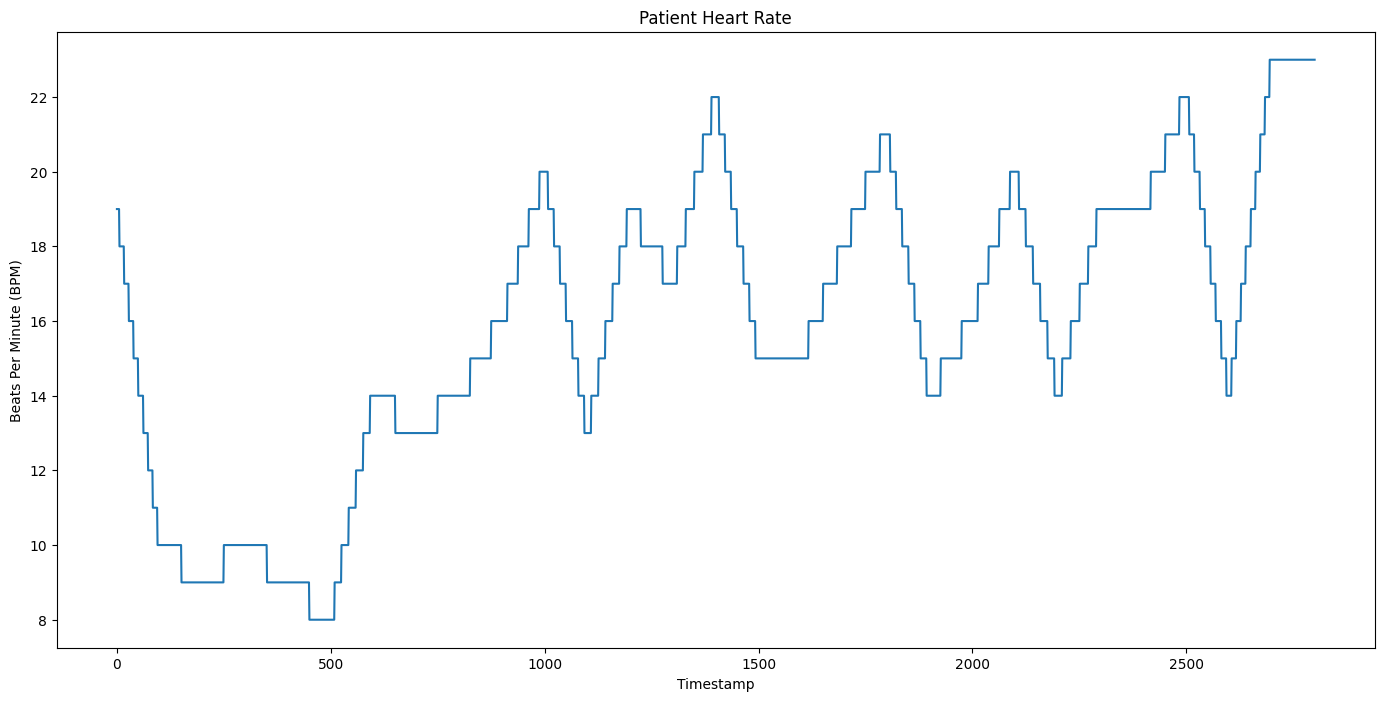

In [14]:
plt.figure(figsize=(17, 8))
plt.plot(patient_data_series)
plt.title('Patient Heart Rate')
plt.ylabel('Beats Per Minute (BPM)')
plt.xlabel('Timestamp')
plt.grid(False)
plt.show()

In [15]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

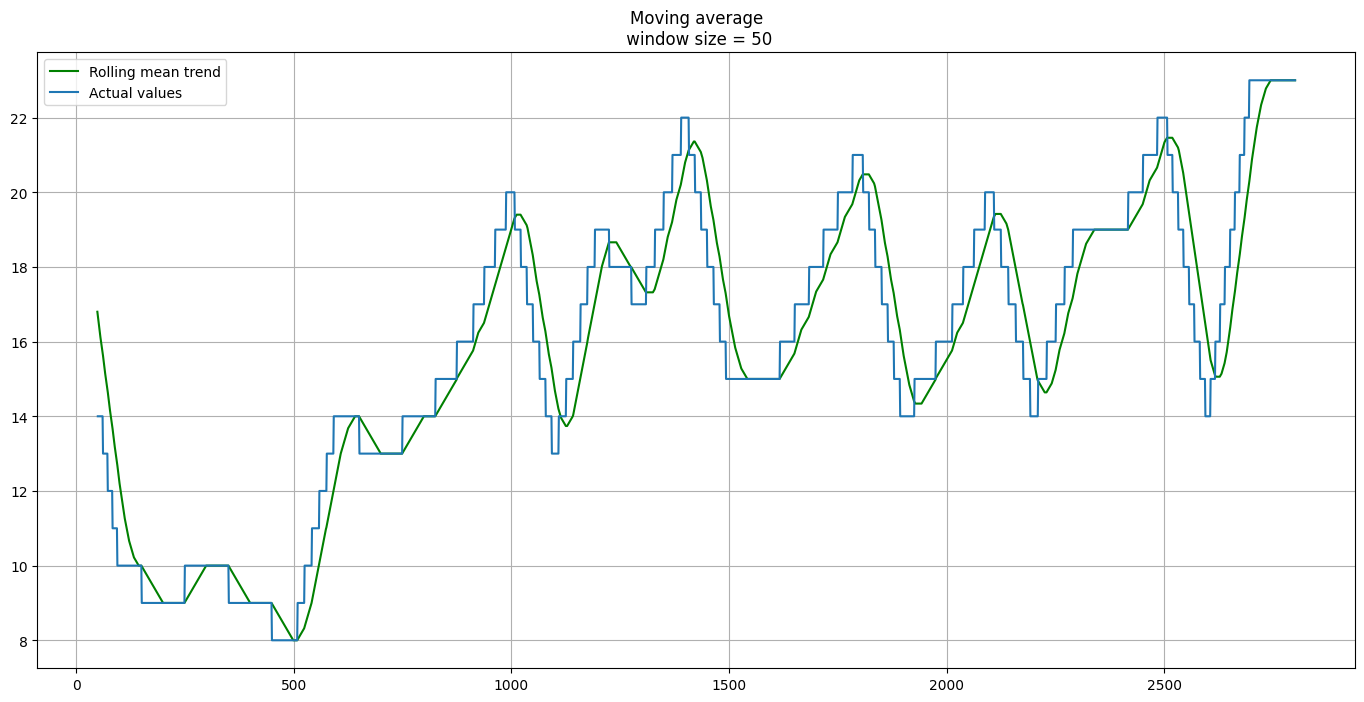

In [16]:
#Smooth by the previous 5 minutes
plot_moving_average(patient_data_series, 50)

In [17]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

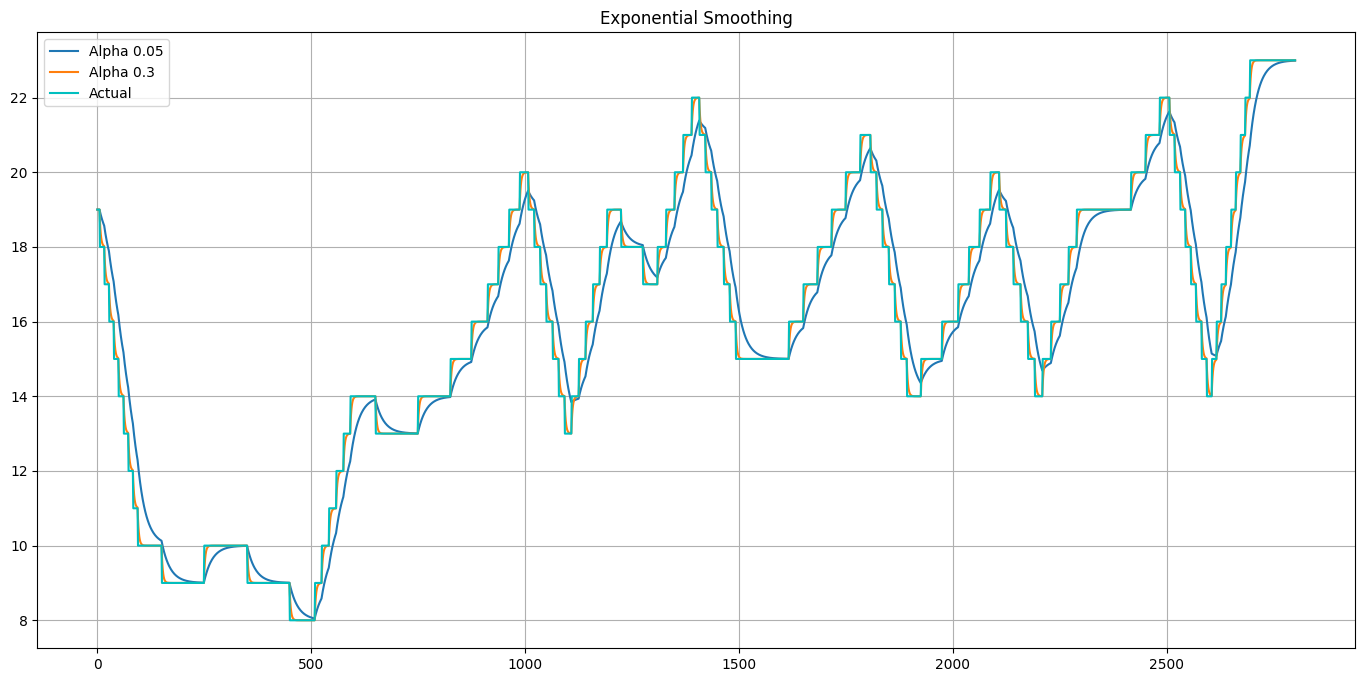

In [19]:
plot_exponential_smoothing(patient_data_series, [0.05, 0.3])

In [20]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [21]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

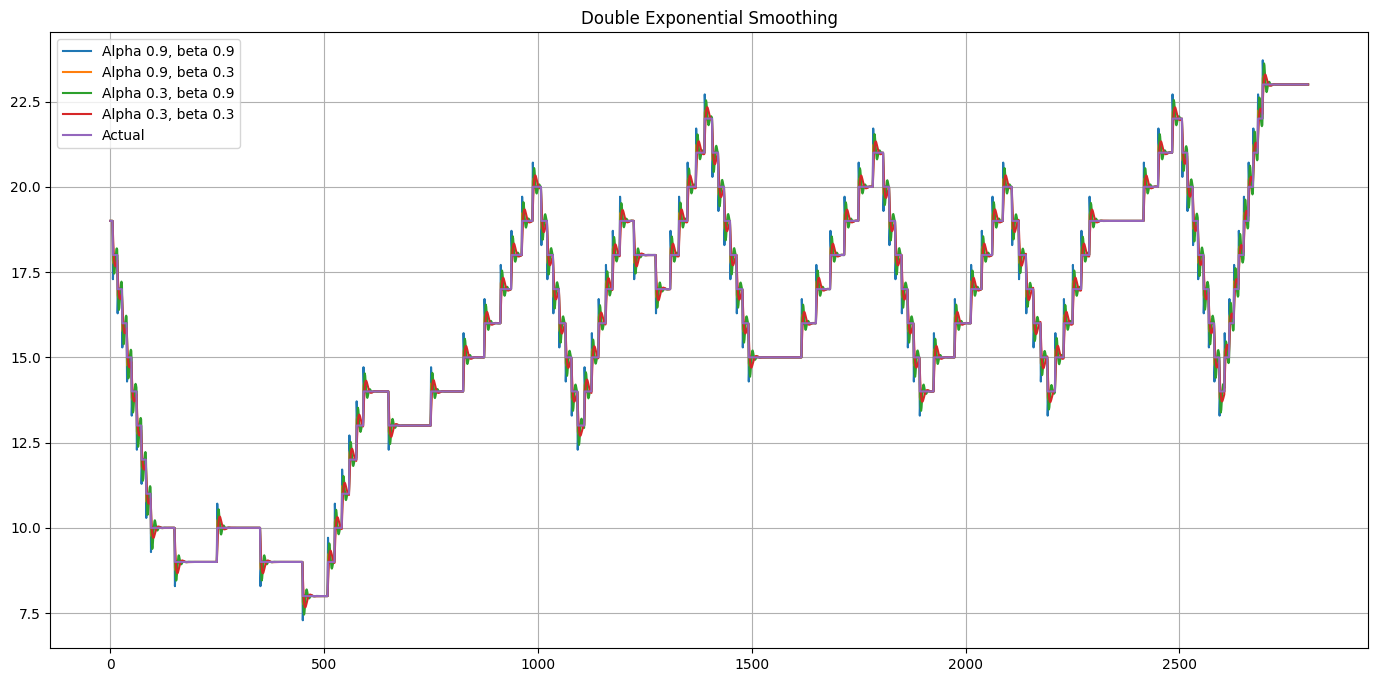

In [22]:
plot_double_exponential_smoothing(patient_data_series, alphas=[0.9, 0.3], betas=[0.9, 0.3])

In [23]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

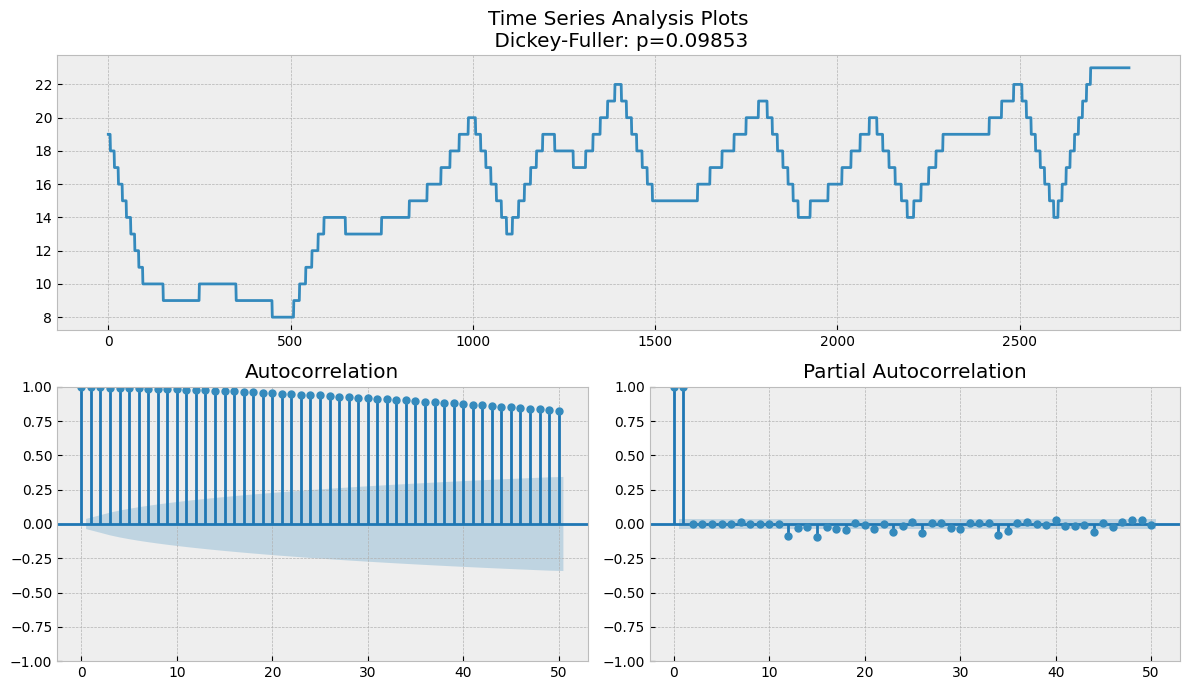

In [24]:
tsplot(patient_data_series, lags=50)

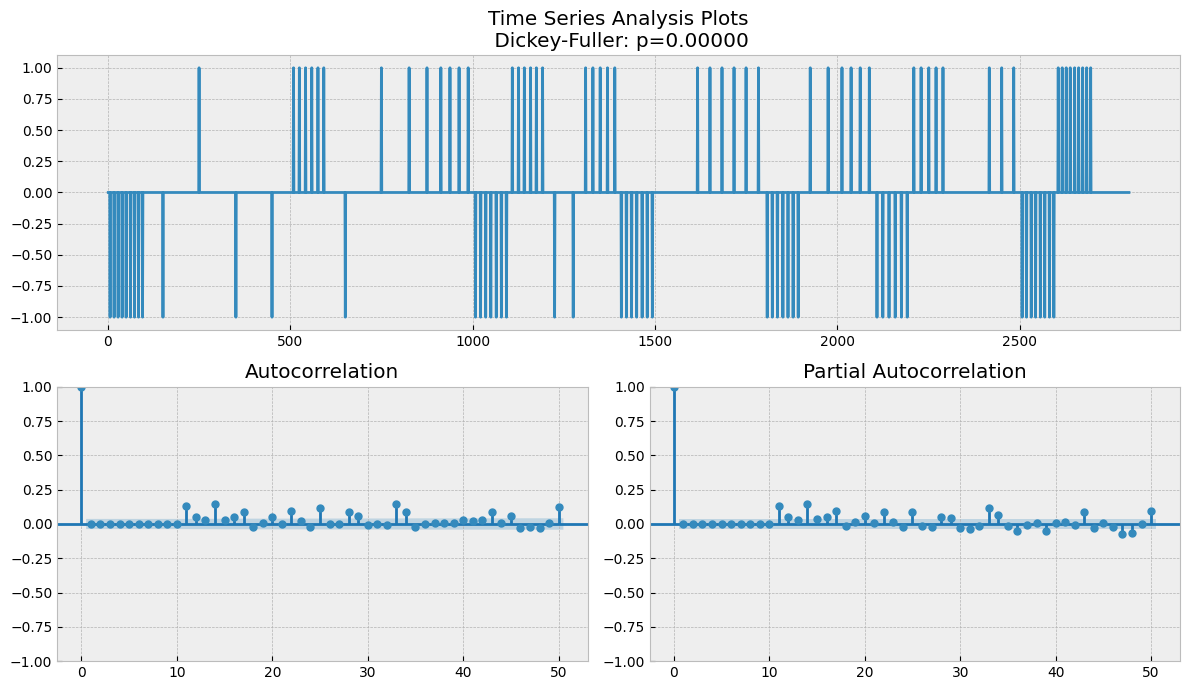

In [25]:
# Take the first difference to remove to make the process stationary
data_diff = patient_data_series - patient_data_series.shift(1)

tsplot(data_diff[1:], lags=50)

# ARIMA

In [26]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

In [27]:
#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [28]:
model = sm.tsa.statespace.SARIMAX(patient_data_series, order=(0, d, 0),
                                               seasonal_order=(2, D, 4, s)).fit(disp=-1)

In [29]:
model.aic

-1239.2953240616391

In [30]:
forecast = model.forecast(100)

In [31]:
pd.DataFrame({"Predicted": forecast, "True": test_data_series})

,Predicted,True
2801,23.003845,23.0
2802,23.001203,23.0
2803,23.000885,23.0
2804,22.987380,23.0
2805,23.003576,23.0
...,...,...
2896,23.134124,21.0
2897,23.133036,21.0
2898,23.138323,21.0
2899,23.135888,21.0


In [32]:
final_df = pd.DataFrame({'PatientID': 138022, 'RespRate': pd.concat([patient_data_series, forecast])})

In [33]:
final_df = final_df.reset_index()

In [34]:
final_df = final_df.rename(columns = {'index': 'Timestamp'})

In [35]:
final_df

,Timestamp,PatientID,RespRate
0,0,138022,19.000000
1,1,138022,19.000000
2,2,138022,19.000000
3,3,138022,19.000000
4,4,138022,19.000000
...,...,...,...
2896,2896,138022,23.134124
2897,2897,138022,23.133036
2898,2898,138022,23.138323
2899,2899,138022,23.135888


In [36]:
hr_df = pd.read_csv('HR_142580.csv')

In [37]:
hr_df

,Timestamp,PatientID,HR
0,0,142580,94.000000
1,1,142580,94.000000
2,2,142580,94.000000
3,3,142580,94.000000
4,4,142580,93.000000
...,...,...,...
2896,2896,142580,111.559502
2897,2897,142580,111.560496
2898,2898,142580,111.578325
2899,2899,142580,111.588025


In [38]:
final_df = final_df.merge(hr_df, on=['Timestamp', 'PatientID'])

In [39]:
final_df

,Timestamp,PatientID,RespRate,HR


In [40]:
# final_df.to_csv('ARIMA_141560.csv')

In [41]:
error = mean_absolute_error(test_data_series, forecast)
print(f'MAE = {error}')

MAE = 1.0770122703178007


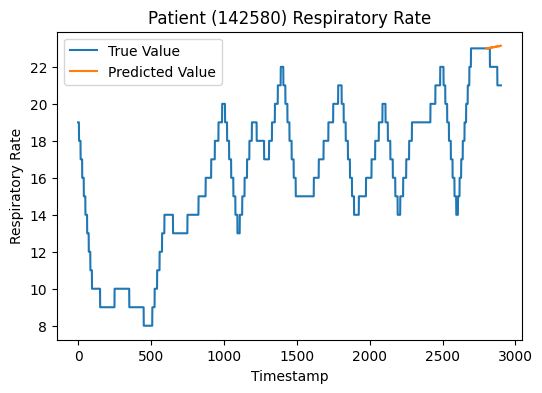

In [42]:
plt.figure(figsize=(6, 4))
plt.plot(pd.concat([patient_data_series, test_data_series]), label='True Value')
plt.plot(forecast, label='Predicted Value')
plt.title('Patient (142580) Respiratory Rate')
plt.ylabel('Respiratory Rate')
plt.xlabel('Timestamp')
plt.grid(False)
plt.legend()
plt.show()

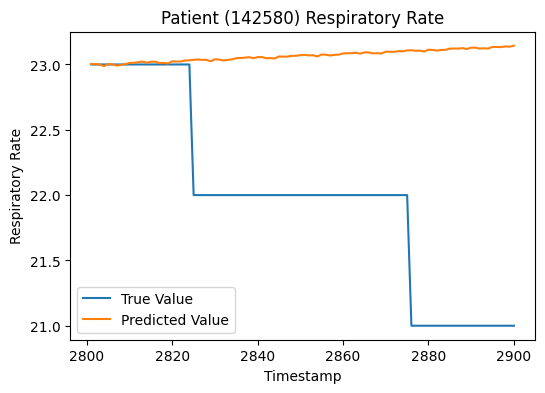

In [43]:
plt.figure(figsize=(6, 4))
plt.plot(pd.concat([patient_data_series, test_data_series])[-100:], label='True Value')
plt.plot(forecast[-100:], label='Predicted Value')
plt.title('Patient (142580) Respiratory Rate')
plt.ylabel('Respiratory Rate')
plt.xlabel('Timestamp')
plt.grid(False)
plt.legend()
plt.show()

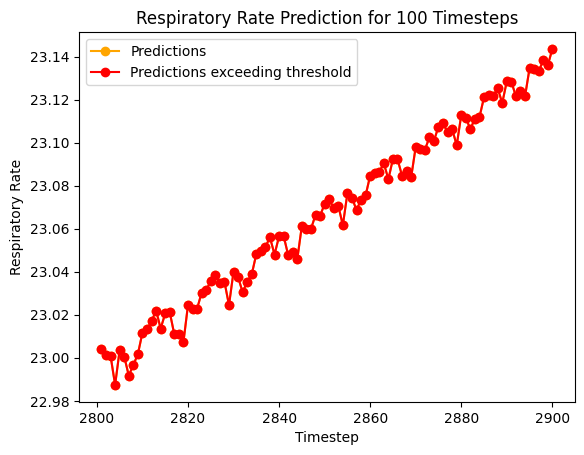

In [44]:
highlight_predictions = [pred if pred > 20 or pred < 12 else None for pred in forecast]

timesteps = np.arange(2801, 2901)

plt.plot(timesteps, forecast, label='Predictions', marker='o', linestyle='-', color='orange')
plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

plt.title('Respiratory Rate Prediction for 100 Timesteps')
plt.xlabel('Timestep')
plt.ylabel('Respiratory Rate')
plt.legend()
plt.show()